# Introduction

The goal of this notebook is to give an example of how a scientist could load the HOTS Shipboard ADCP data into a python environment for analysis use.

1. Setup/bookkeeping
2. Then we show some common plots that may be desired.
3. Then we do a time series comparison

## Next Steps/Uses
For a user 
* Find an interesting trend in the data you want to explore
* Learn more about ocean currents via shipboard ADCP data
* Explore more data sets like the ones found in the discussion for the dataset https://www.kaggle.com/datasets/davidvadnais/hawaii-ocean-times-series-shipboard-adcp-data/discussion/543470

## TODO
* demo pycurrents and show more interesting time series analysis

## Linked references/Further reading
**This is the main document we are pulling from**<br>
Julia M Hummon, et al. CODAS+UHDAS Documentation. 282:c289b3782d3a, Zenodo, 22 Sept. 2023, doi:10.5281/zenodo.8371260.

In [1]:
%%capture cell_output
# We have surpressed the output of this cell for clarity. The waf build is verbose and not the focus of this notebook
!pip install netCDF4 mercurial

# Clone mercurial repos of codas and pycurrents
!hg clone https://currents.soest.hawaii.edu/hg/codas3
!hg clone https://currents.soest.hawaii.edu/hg/pycurrents

# Install codas3 then pycurrents
!cd codas3 && ./waf configure --python_env && ./waf build &&./waf install
!cd pycurrents && pip install .


# 1. Setup

In [2]:
import requests
import netCDF4 as nc
from netCDF4 import num2date
import io
from bs4 import BeautifulSoup
import os
import matplotlib.pyplot as plt
from pathlib import Path
# import pycurrents.adcp.panelplotter as pp
import numpy as np
import math 
from scipy.stats import spearmanr, pearsonr

In [3]:
# List files in the current directory
data_dir = "/kaggle/input/go-ship-shipboard-adcp-data/"
nc_dir = "/contour/"
desired_file_ending = "_short.nc"
directories = os.listdir(data_dir)

# get cruise tracks
cruise_track_set = set()

for directory in directories:
    # Split the filename by underscores
    cruise_track_set.add(directory.split('_')[1])


# load data
datasets_files = []
for directory in directories:
    cruise_track = directory.split('_')[1]
    year = directory.split('_')[0]
    #print(file_loc)
    all_nc_files = ""
    short_file = ""
    try:
        file_loc = f"{data_dir}{directory}{nc_dir}"
        all_nc_files = os.listdir(file_loc)

        #print(all_nc_files)
        short_file = next((os.path.join(file_loc, file) for file in all_nc_files if file.endswith('_short.nc')), None)
        profile = short_file.split('/')[-1]
        datasets_files.append([nc.Dataset(short_file), cruise_track, year,profile])
        
    except FileNotFoundError:
        # handle n sonars
        sonars_dir = f"{data_dir}{directory}"
        sonar_dirs = [d for d in os.listdir(sonars_dir) if os.path.isdir(os.path.join(data_dir, d))]
        for sonar in sonar_dirs:
            file_loc = f"{data_dir}{directory}/{sonar}{nc_dir}"
            #print(file_loc)
            all_nc_files = os.listdir(file_loc)
            short_file = next((os.path.join(file_loc, file) for file in all_nc_files if file.endswith('_short.nc')), None)
            profile = short_file.split('/')[-1]
            datasets_files.append([nc.Dataset(short_file), cruise_track, year, profile])

In [4]:
# EXAMPLE : get year from data
dataset = datasets_files[1][0]
print(dataset.variables.keys())
time_var = dataset.variables['time']
time_values = num2date(time_var[:], units=time_var.units)
year = time_values[0].year
print(f"The year of the first time value is: {year}")

dict_keys(['trajectory', 'time', 'lon', 'lat', 'depth', 'u', 'v', 'amp', 'pg', 'pflag', 'heading', 'tr_temp', 'num_pings', 'uship', 'vship'])
The year of the first time value is: 2013


# 2. Basic Plotting

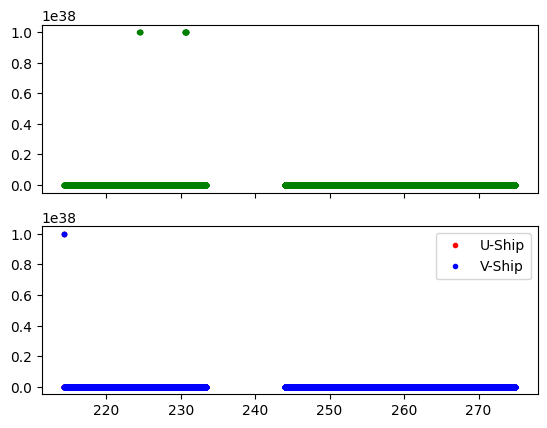

In [5]:
# example plot heading over time
f,ax = plt.subplots(nrows=2, sharex=True)
# fix missed data with nan
heading = np.array(dataset['heading'])
u_ship = np.array(dataset['uship'])
v_ship = np.array(dataset['vship'])
time = np.array(dataset['time'])

# Plot heading in green
ax[0].plot(time, heading, 'g.', label='Heading')

# Plot u_ship in red and v_ship in blue on the second axis
ax[1].plot(time, u_ship, 'r.', label='U-Ship')
ax[1].plot(time, v_ship, 'b.', label='V-Ship')  

ax[1].legend()

plt.show()

This gap corresponds to a start/stop event in the data.  

# 3. Time series comparison 

A16S in year 2014
(80,) (80,) (80,)
A16S in year 2014
(60,) (60,) (60,)
A16S in year 2005
(56,) (56,) (56,)
A16S in year 2005
(56,) (56,) (56,)


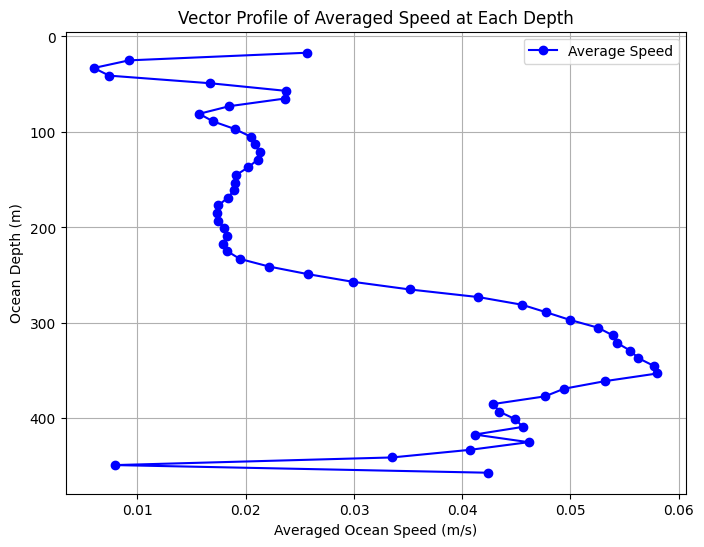

In [6]:
# Compare ocean velocities on a trackby year
# lets start by making a single plot
track = 'A16S'
speed_avgs = []
depth_list = []
profile_list = []
# dataglob [nc, track, year]
for data_glob in datasets_files:
    if data_glob[1] == track:
        print(f"{data_glob[1]} in year {data_glob[2]}")
        #this_track_data.append(data_glob)
        dataset = data_glob[0]
        u = dataset.variables['u'][:]  
        v = dataset.variables['v'][:]  
        depth = dataset.variables['depth'][:] 
        time = dataset.variables['time'][:]  
        

        u_avg = np.mean(u, axis=0)  # Averaging over the time dimension (axis=0)
        v_avg = np.mean(v, axis=0)  # Averaging over the time dimension (axis=0)
        # Now u_avg and v_avg will contain the average values at each depth
        

        speed_avg = np.sqrt(u_avg**2 + v_avg**2)
        speed_avgs.append(speed_avg)
        print(u_avg.shape, v_avg.shape, speed_avg.shape)
        depth_list.append(depth[0])
        profile_list.append(data_glob[3])
        

#looking at the last data piece 
plt.figure(figsize=(8, 6))
plt.plot(speed_avg, depth[0], marker='o', color='b', label='Average Speed')
plt.gca().invert_yaxis()  # Invert the y-axis to show the deepest point at the bottom
plt.xlabel('Averaged Ocean Speed (m/s)')  
plt.ylabel('Ocean Depth (m)') 
plt.title('Vector Profile of Averaged Speed at Each Depth')  # Title of the plot
plt.grid(True)
plt.legend()
plt.show()


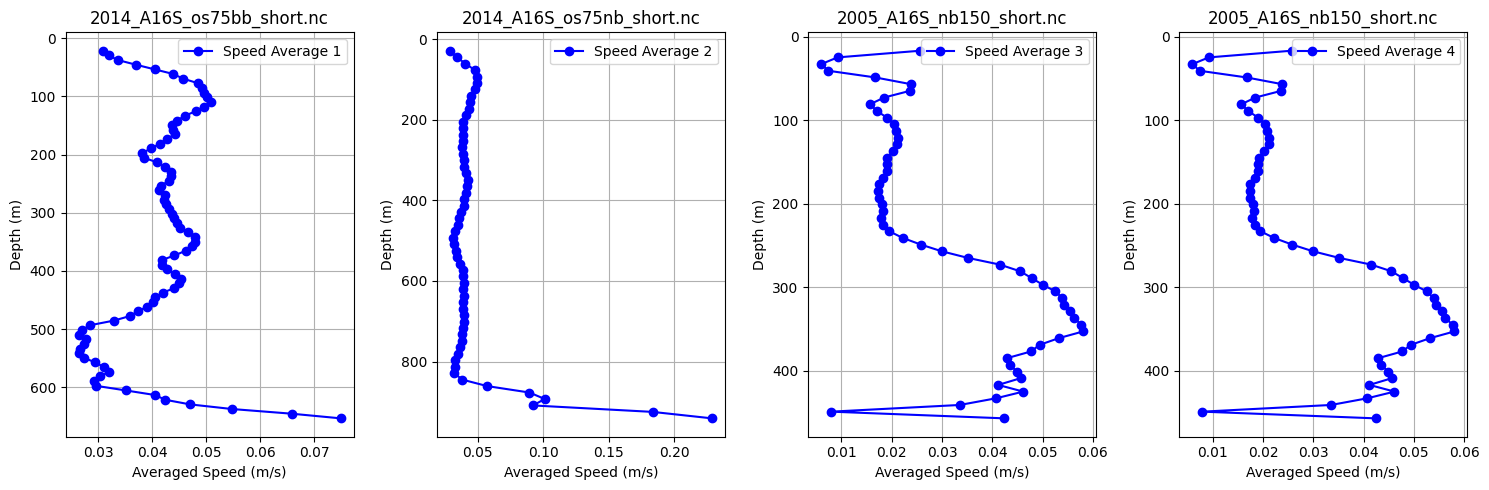

In [7]:
# Neat! now we know the average ocean velocity on track A20 by depth. 
# Lets plot each sonar and each year
# Create a figure and axes for subplots (e.g., 1 row and 3 columns)
fig, axes = plt.subplots(1, len(speed_avgs), figsize=(15, 5))

# Iterate over each speed average and its corresponding axis
for i, avg_speed in enumerate(speed_avgs):
    axes[i].plot(avg_speed, depth_list[i], marker='o', color='b', label=f'Speed Average {i + 1}')
    axes[i].invert_yaxis()  # Invert the y-axis to show the deepest point at the bottom
    axes[i].set_xlabel('Averaged Speed (m/s)')  
    axes[i].set_ylabel('Depth (m)') 
    axes[i].set_title(profile_list[i])  # Title for each subplot
    axes[i].grid(True)  # Enable grid
    axes[i].legend()

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()

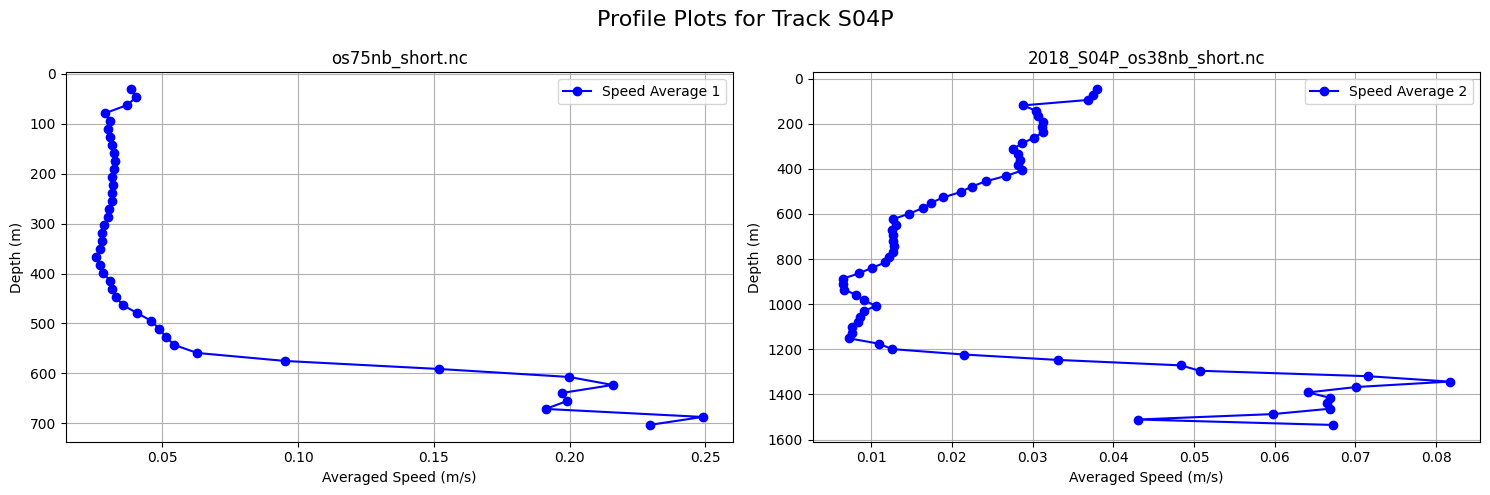

skipped I05


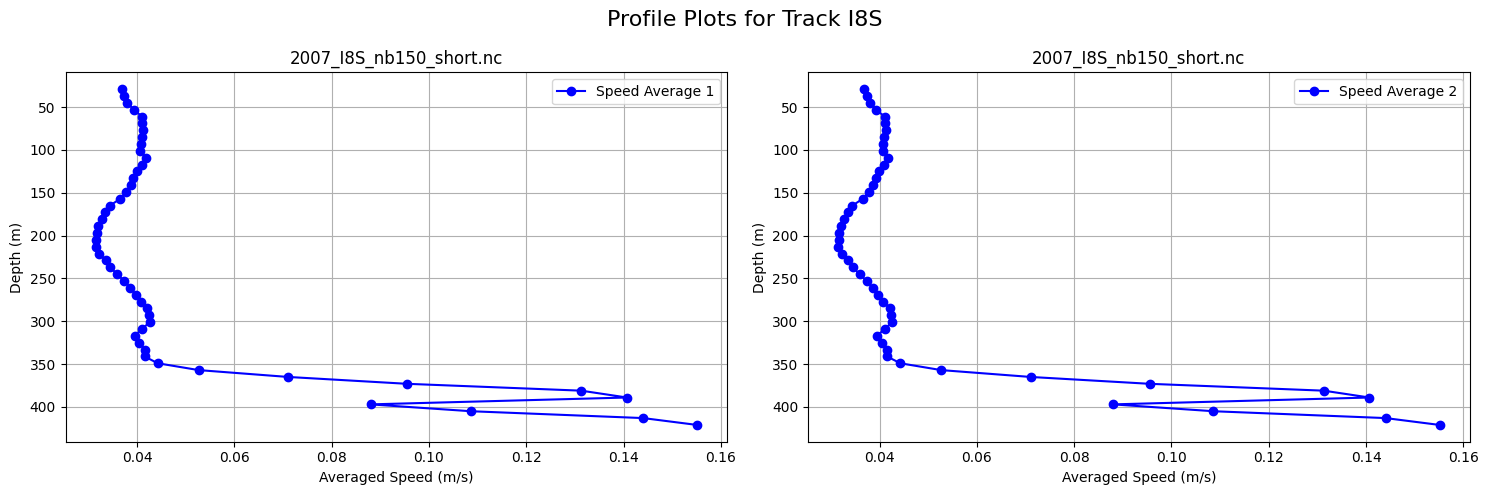

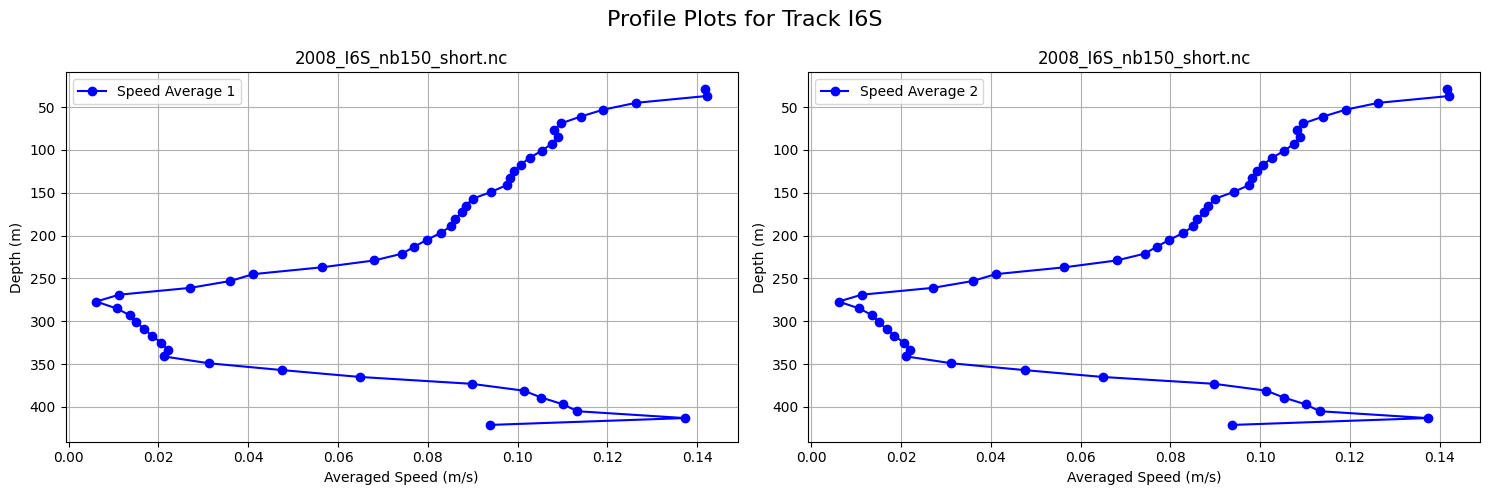

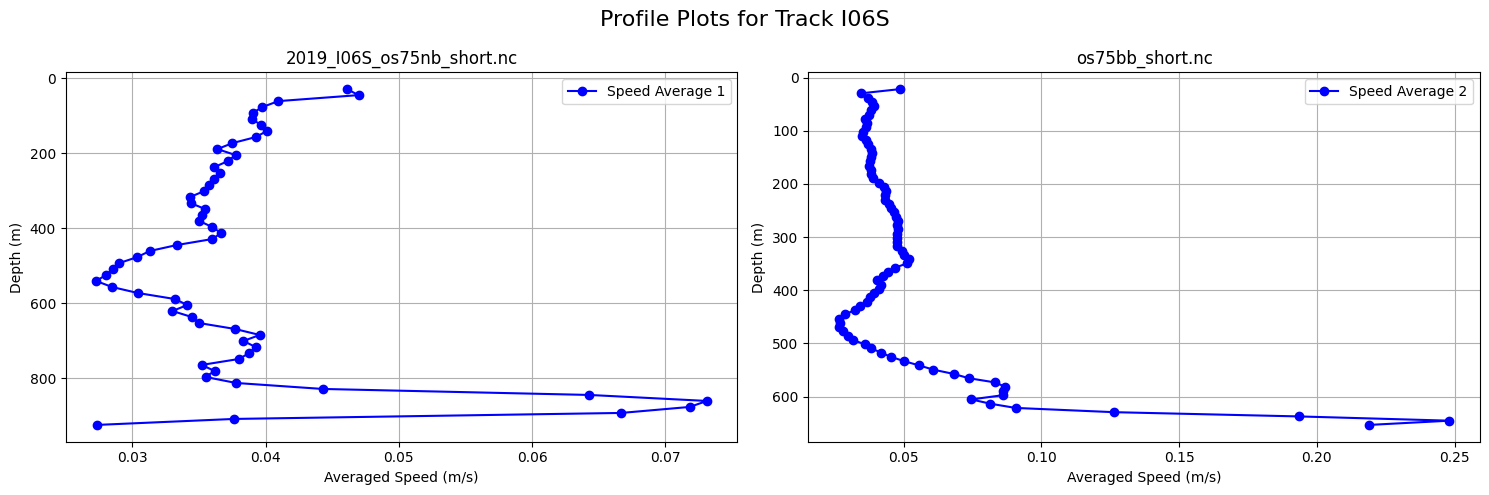

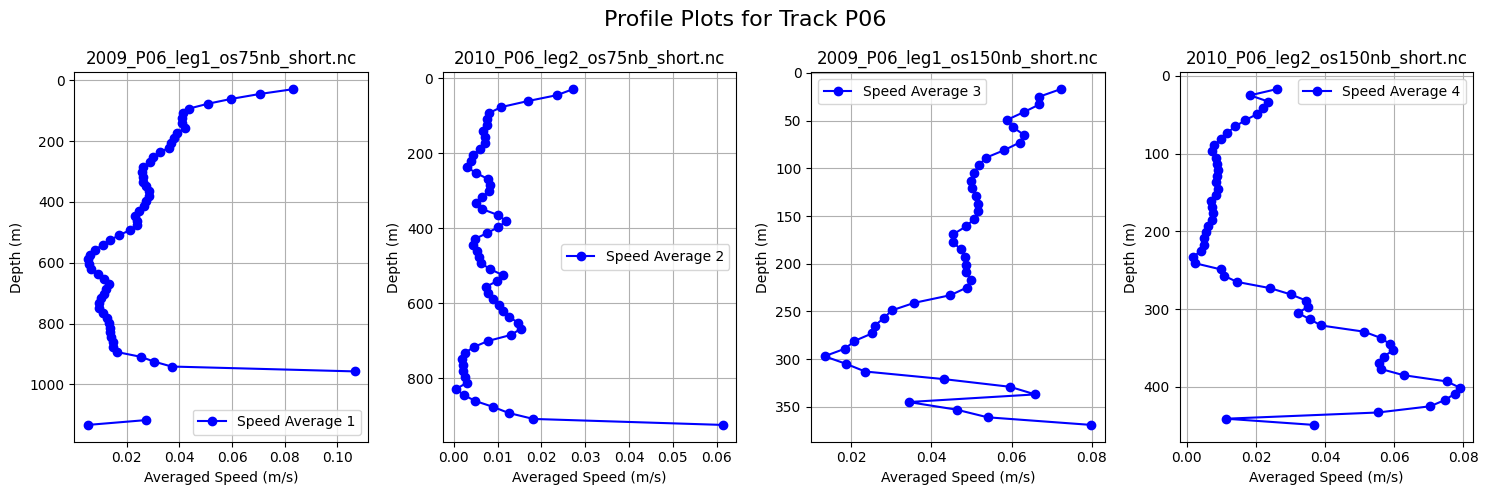

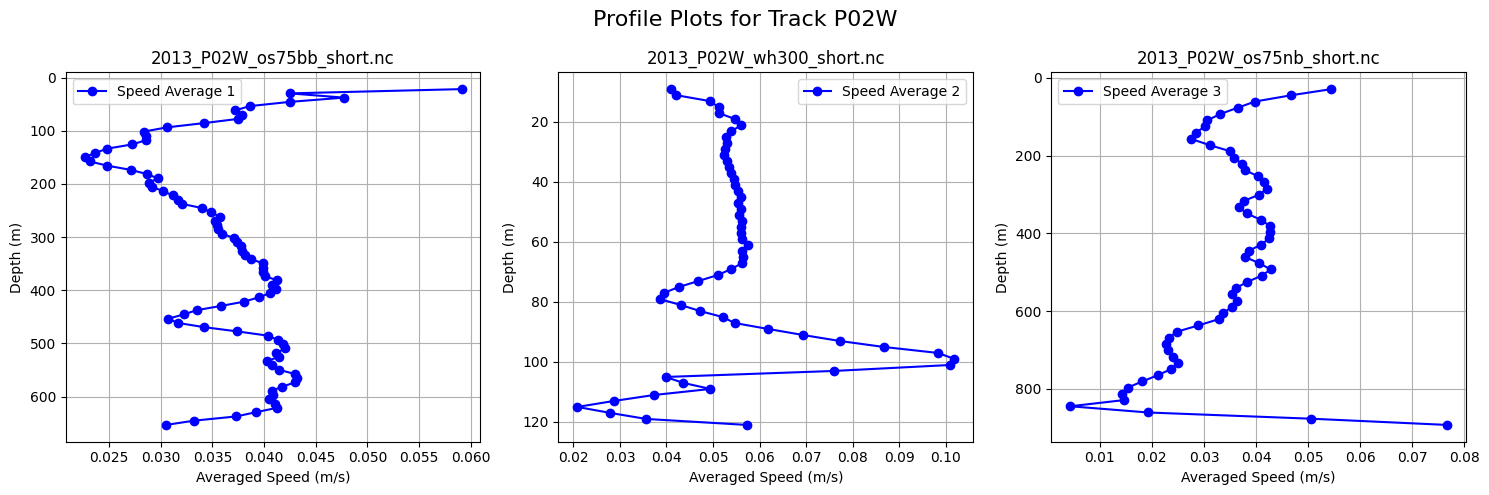

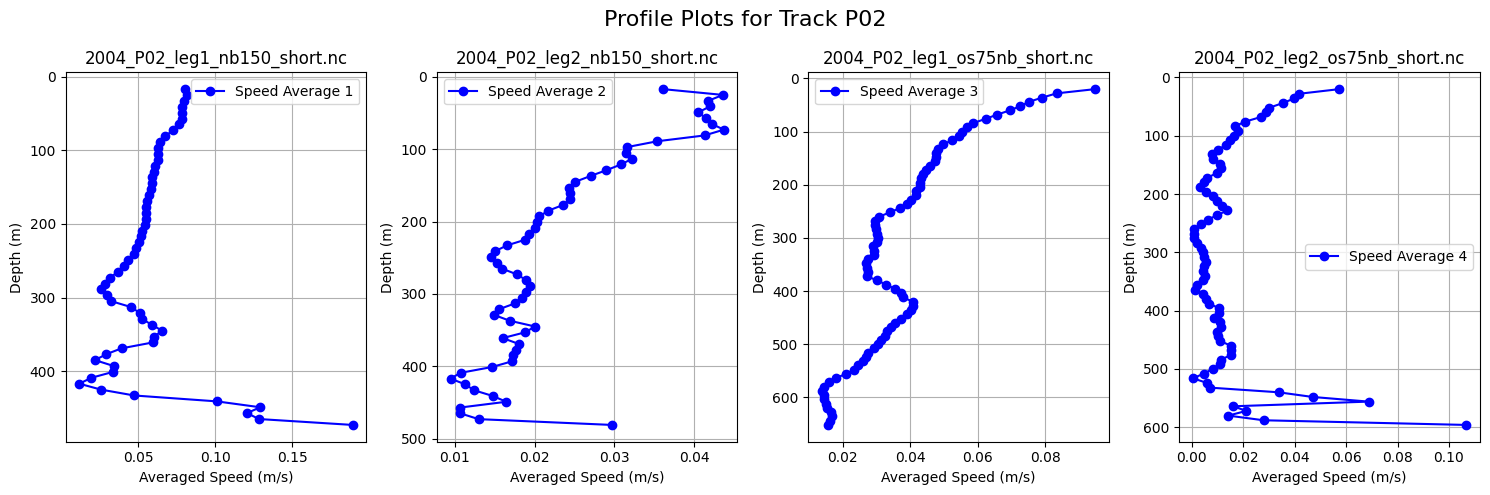

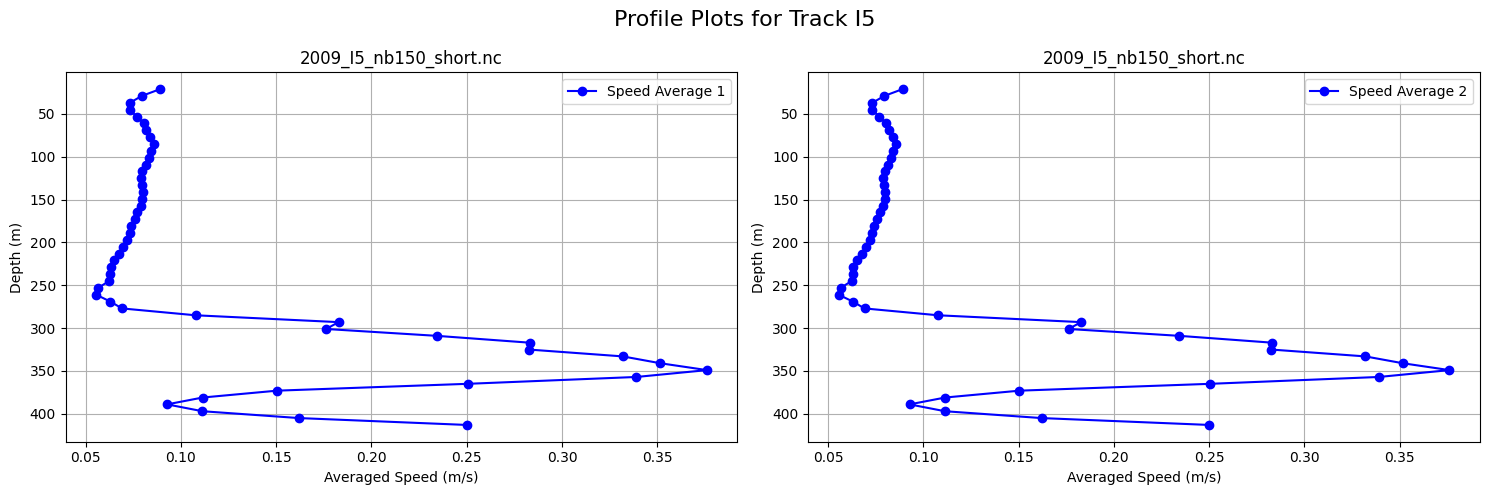

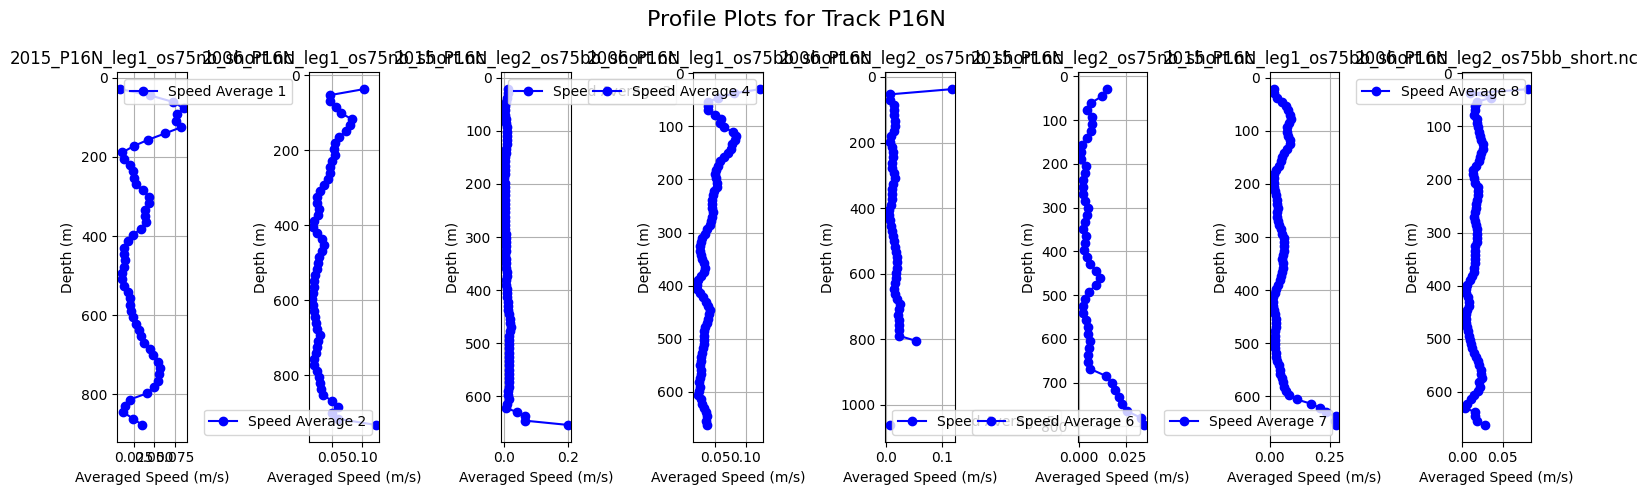

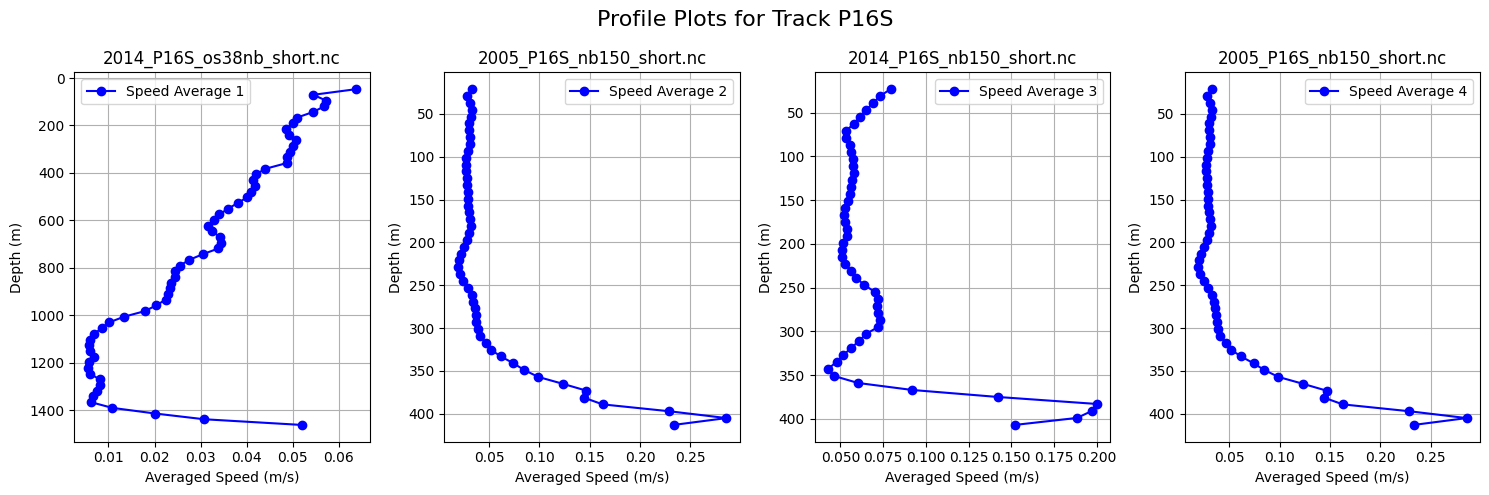

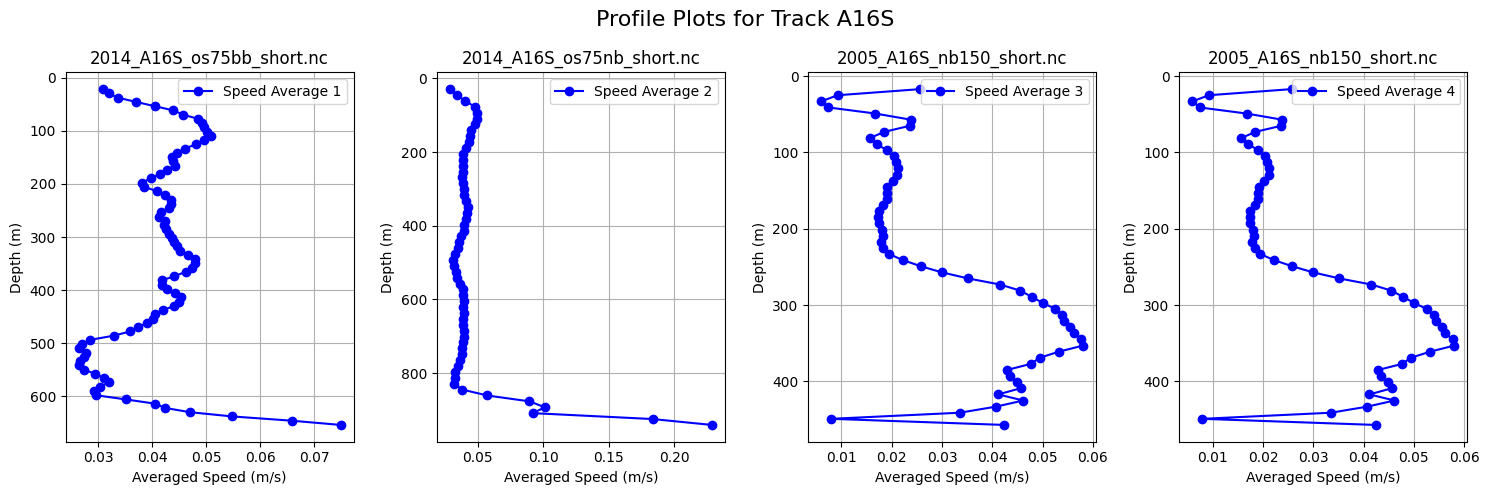

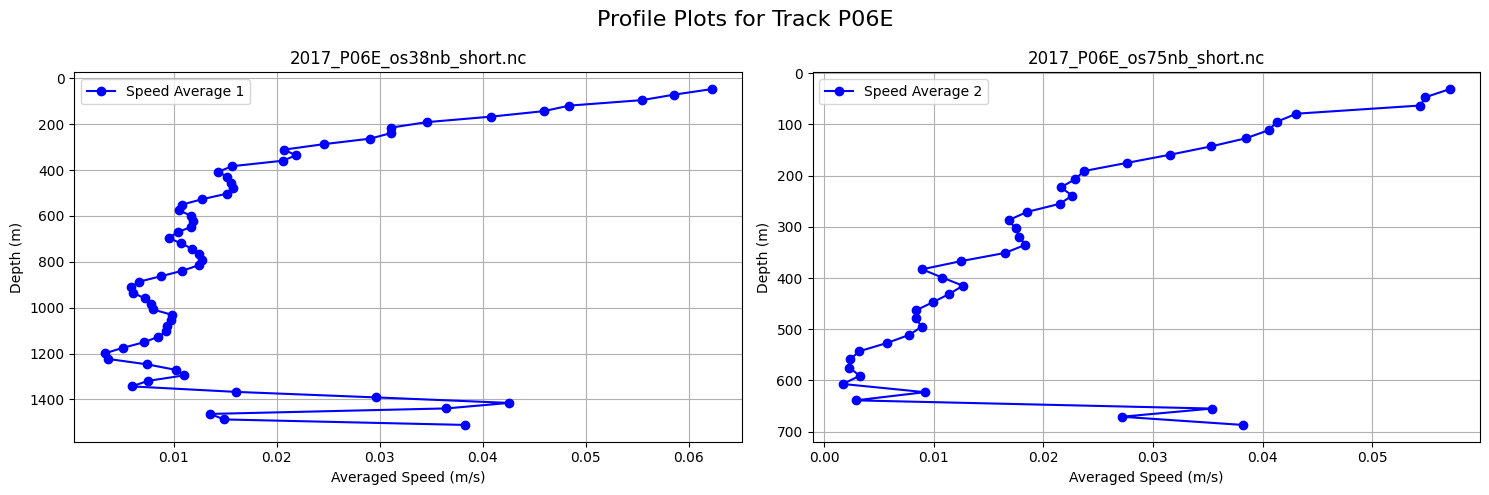

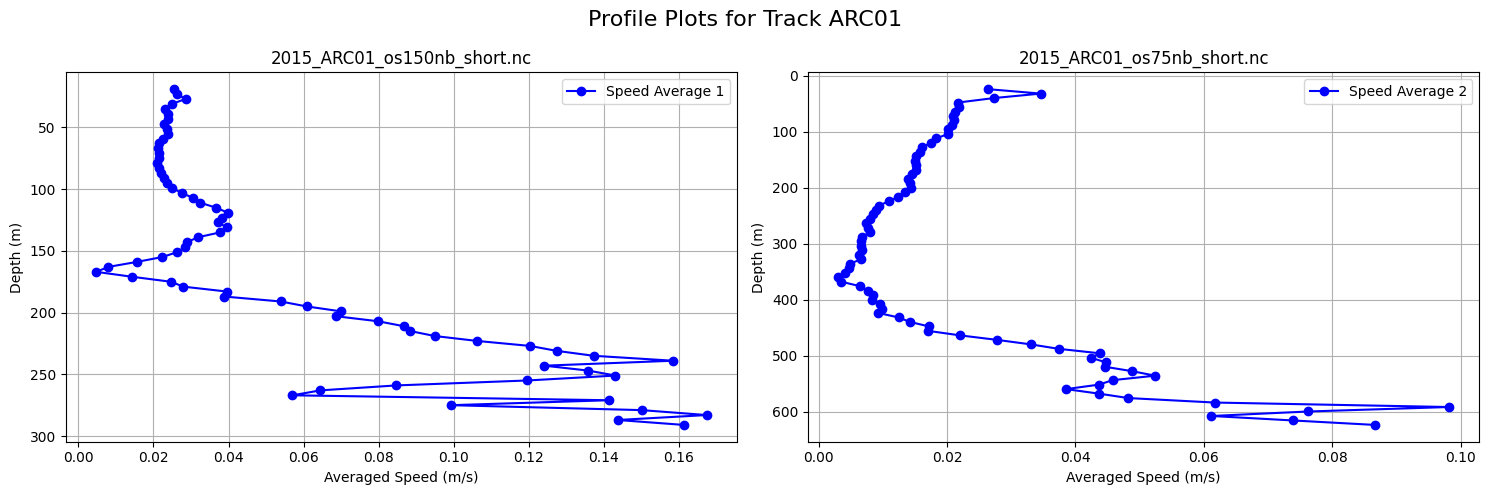

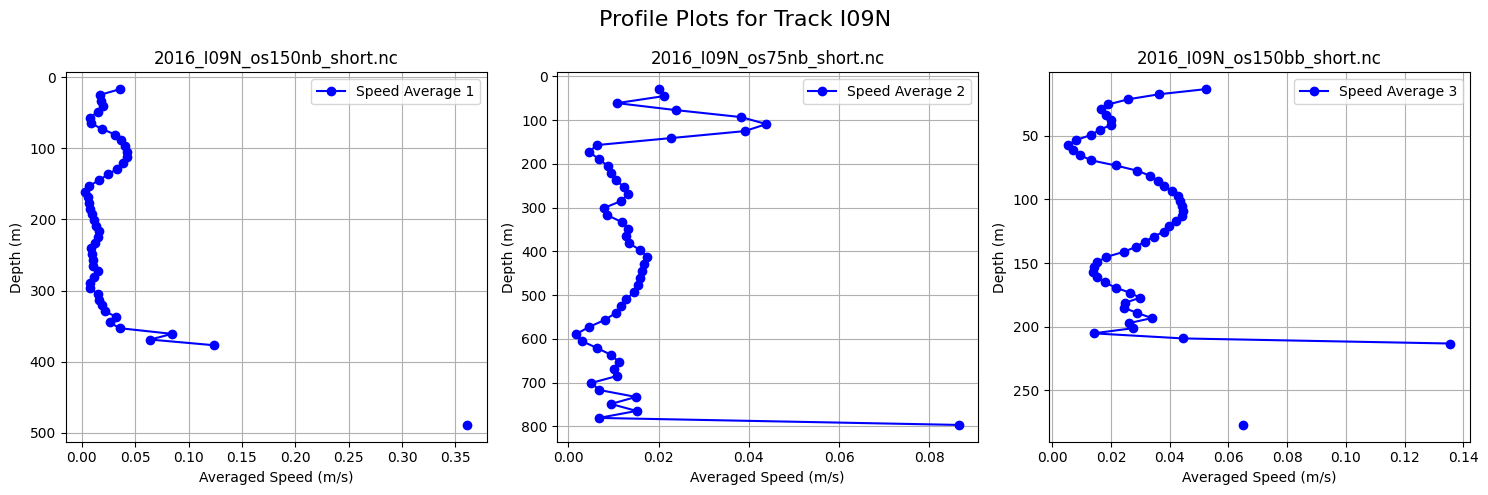

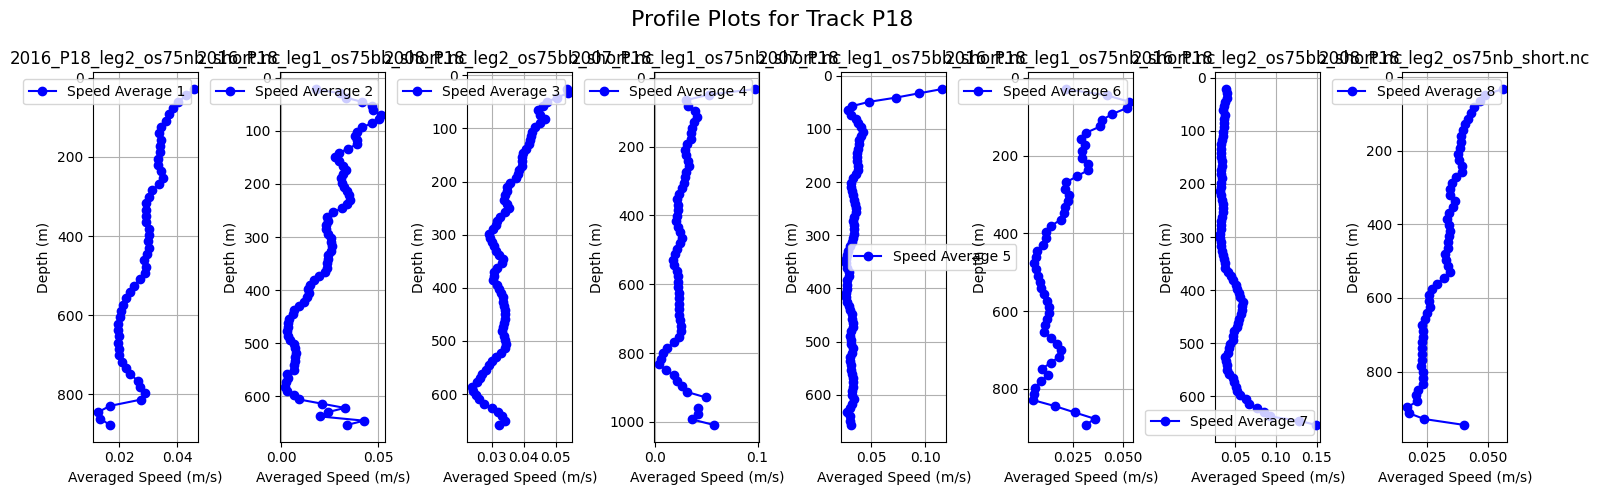

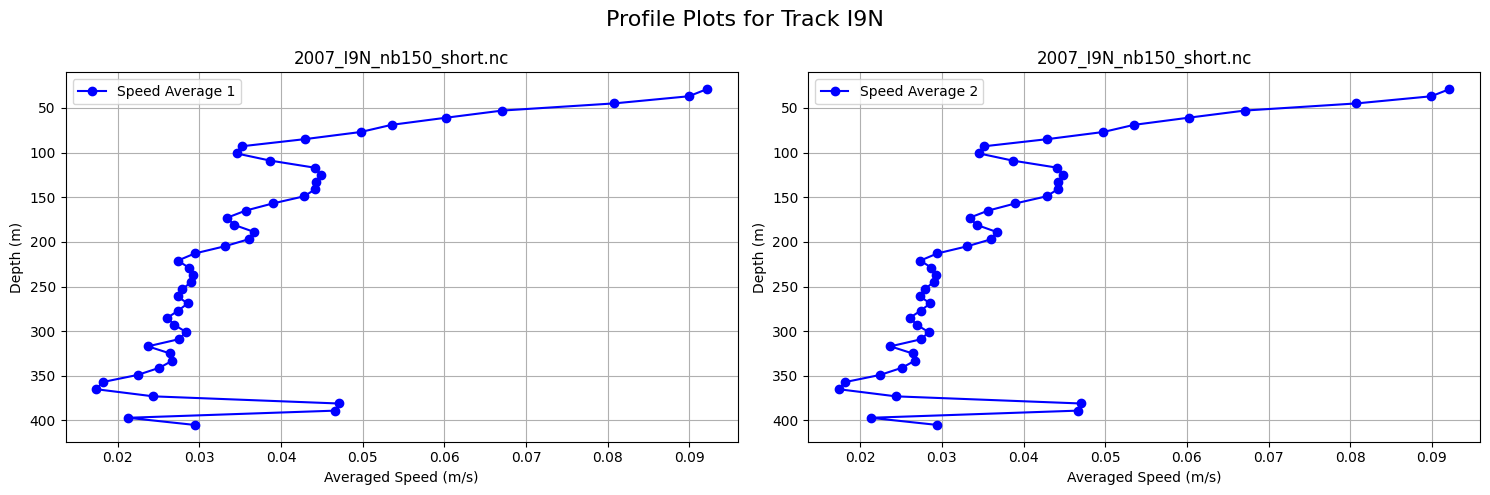

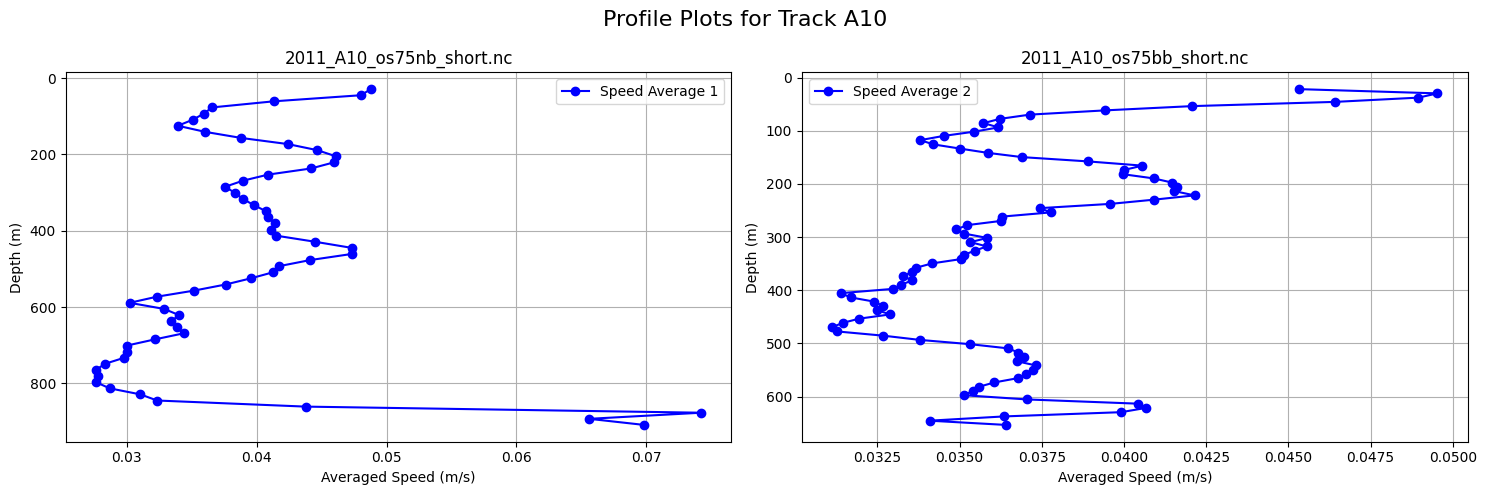

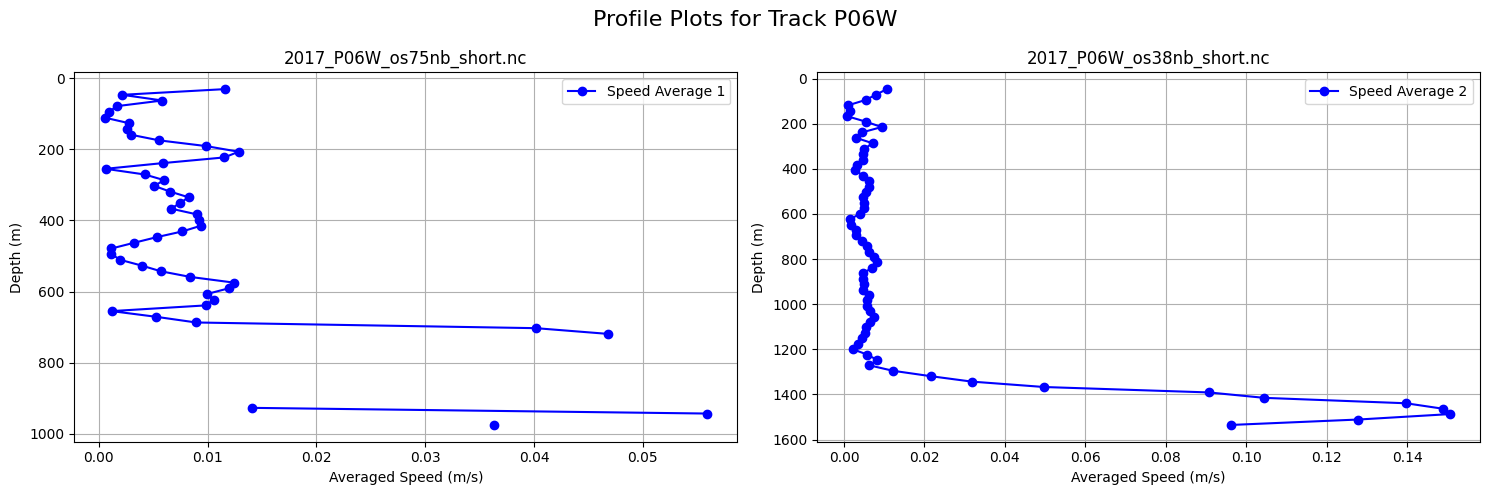

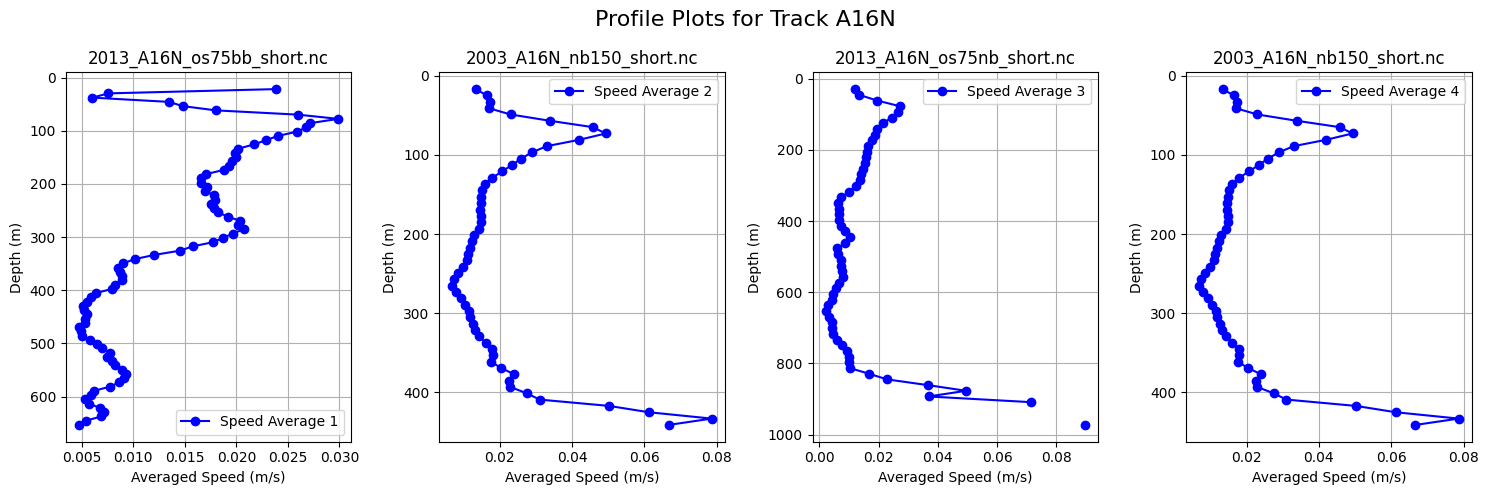

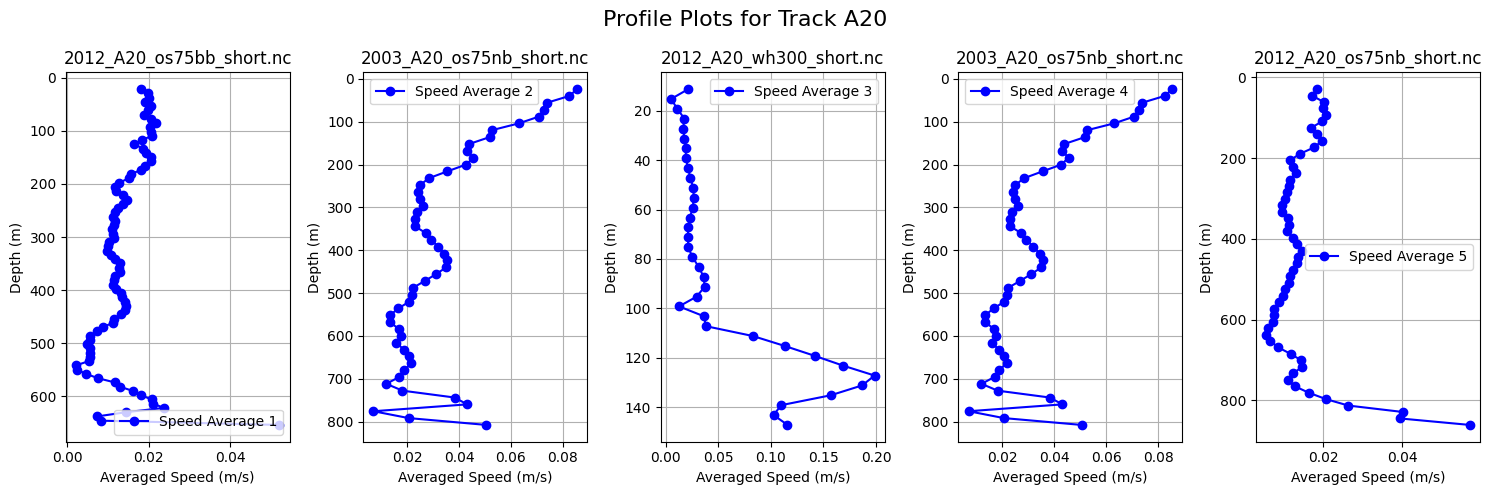

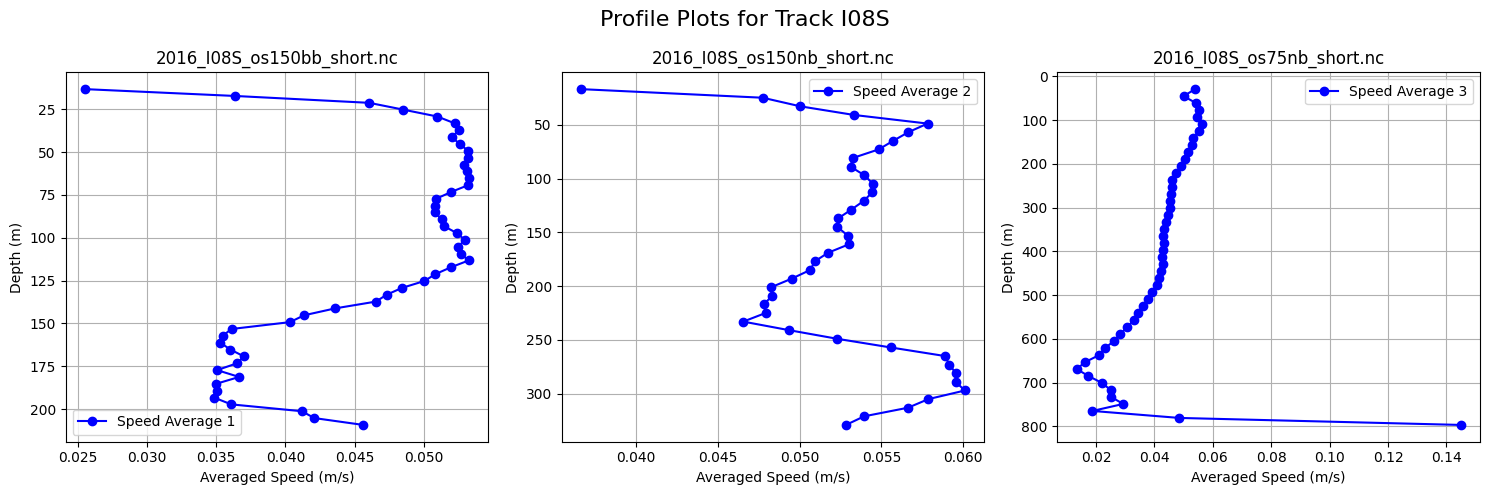

skipped A13p5


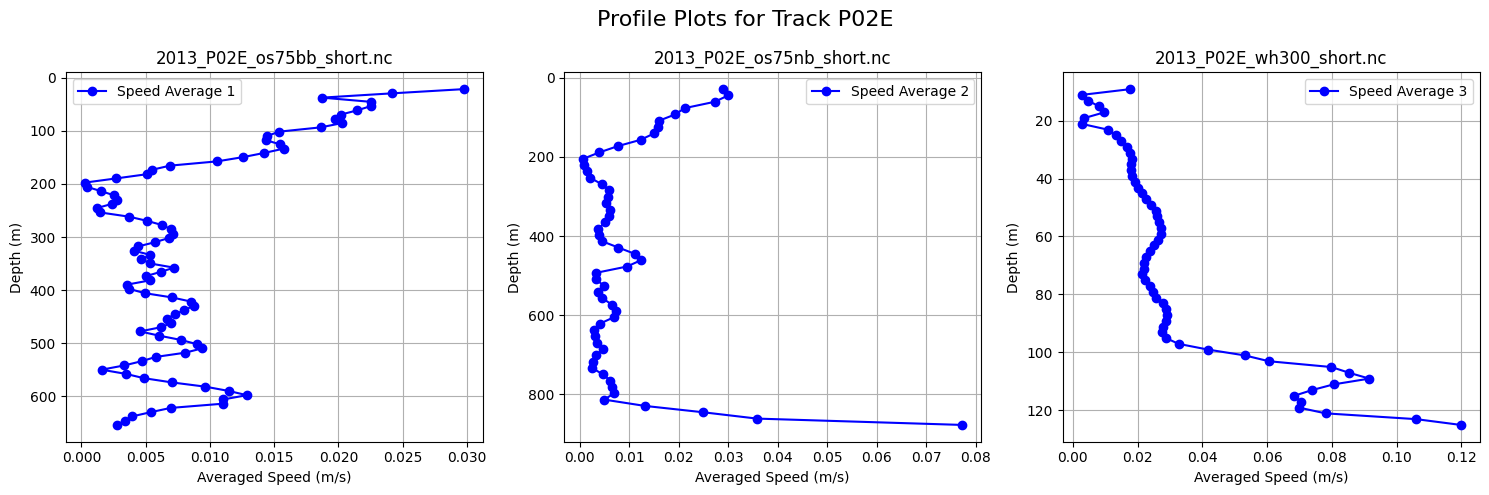

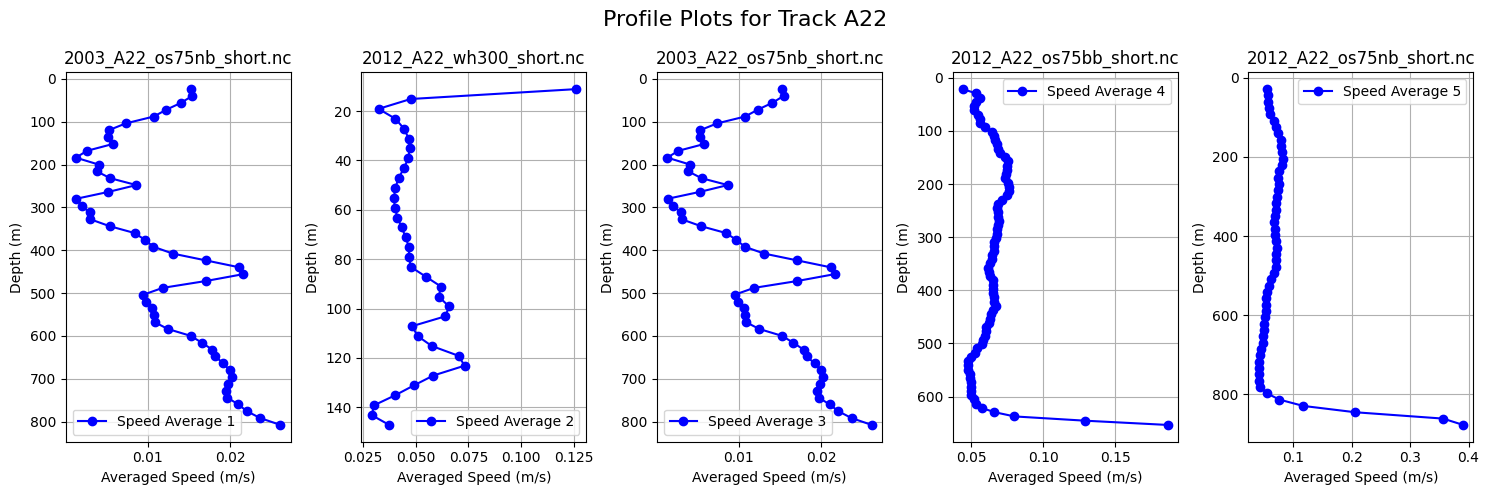

In [8]:
for track in cruise_track_set:
    speed_avgs = []  # List to store speed averages for each profile
    depth_list = []  # List to store depth for each profile
    profile_list = []  # List to store profile names for titles

    # Collect data for each profile in the current track
    for data_glob in datasets_files:
        if data_glob[1] == track:
            #print(f"{data_glob[1]} in year {data_glob[2]}")
            
            dataset = data_glob[0]  
            
            try:
                u = dataset.variables['u'][:]
            except RuntimeError:
                print(f"runtime error on {data_glob[3]}")
                continue
            v = dataset.variables['v'][:]
            depth = dataset.variables['depth'][:]
            time = dataset.variables['time'][:]
            
            # Averaging u and v over the time dimension
            u_avg = np.mean(u, axis=0)  # Averaging over the time dimension (axis=0)
            v_avg = np.mean(v, axis=0)  # Averaging over the time dimension (axis=0)
            
            # Calculate the speed magnitude at each depth
            speed_avg = np.sqrt(u_avg**2 + v_avg**2)
            
            # Append results for this dataset (this profile)
            speed_avgs.append(speed_avg)
            depth_list.append(depth[0])  # Assuming depth is consistent across time
            profile_list.append(data_glob[3])  # profile name is in index 3
    
    # Create panel plots for each track
    # Create a figure with multiple subplots (one for each profile in the track)
    num_profiles = len(speed_avgs)
    if num_profiles == 0: 
        print(f"skipped {track}")
        continue
    fig, axes = plt.subplots(1, num_profiles, figsize=(15, 5))

    # If only one profile, `axes` is not a list, so we handle that
    if num_profiles == 1:
        axes = [axes]

    # Plot each profile in a subplot
    for i, avg_speed in enumerate(speed_avgs):
        axes[i].plot(avg_speed, depth_list[i], marker='o', color='b', label=f'Speed Average {i + 1}')
        axes[i].invert_yaxis()  # Invert y-axis to show deepest point at the bottom
        axes[i].set_xlabel('Averaged Speed (m/s)')
        axes[i].set_ylabel('Depth (m)')
        axes[i].set_title(profile_list[i])  # Title with the profile name (e.g., Profile1, Profile2)
        axes[i].grid(True)
        axes[i].legend()

    # Set the overall title for the set of subplots for this track
    fig.suptitle(f'Profile Plots for Track {track}', fontsize=16)
    
    # Adjust layout to avoid overlap and make the plot look clean
    plt.tight_layout()
    
    # Show the plot
    plt.show()
        

There is a lot that can be gleaned from exploring this dataset.  I hope you enjoy learning more about Ocean Currents!